<a href="https://colab.research.google.com/github/samvardhan/stan_workshop/blob/main/stan_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
!pip install pystan

In [154]:
# this is needed to enable running stan (there is a bug )
!pip install nest_asyncio

In [165]:
import stan
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import nest_asyncio
nest_asyncio.apply()

# **LINEAR REGRESSION**!

---
## General Formula
##  Y = alpha + beta * X + e
### e ~ N(0,sigma)

---





Generate Data

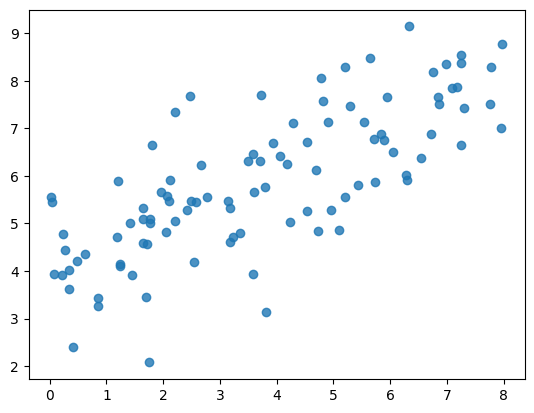

In [204]:
# Parameters to be inferred

alpha = 4.0  #intercept
beta = 0.5 #slopes
sigma = 1.0 #error

# Generate data
x =  8 * np.random.rand(100)

y = alpha + beta * x
y = np.random.normal(y, scale=sigma) #noise

#visualize generated data
plt.scatter(x, y, alpha = 0.8)

Build STAN model block

In [190]:
model = """
data {                    //input the data to STAN
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {              //define parameters for the model
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {                   //define the model structure, and priors

    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1);   //why?

    //model
    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {    //get quantities of interest from fitted model
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);             //generate samples from model
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma); //probability of data given the model and parameters
        }
}
"""

Model Parameters

In [208]:
#STAN takes data as a dict
data = {'N': len(x), 'x': x, 'y': y}

#parameters for STAN fitting
chains = 2
samples = 1000
warmup = 10
# set seed


# Compile the model
posterior = stan.build(model, data=data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   5% (200/4000)
Sampling:  12% (500/4000)
Sampling:  30% (1200/4000)
Sampling:  45% (1800/4000)
Sampling:  72% (2900/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
  Adjust your expectations accordingly!


In [192]:
# Extracting traces

alpha = fit['alpha'].reshape(chains,samples) #arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)


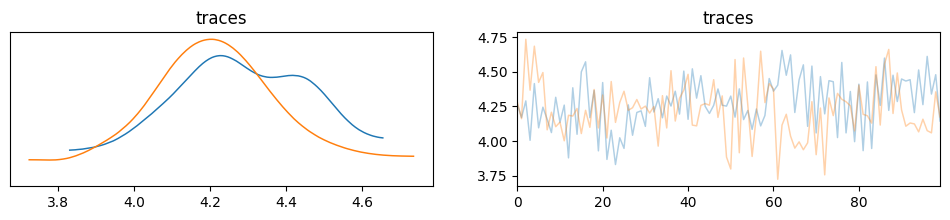

In [193]:
varname = alpha
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('traces')

In [ ]:
az.plot_posterior(beta)

## EXERCISE: Re-Run Linear Regression: 'Try to fail'

Try to make the model convergence fail. To achieve this, you can either-

- Reduce number of iterations *N*
- Use strongly informative but wrong priors for *alpha* or *beta*
few more
(ex. alpha ~ uniform(0,3))
beta ~ uniform(1,2)

Have them explain what way convergence is failed
Not reaching area or not sampling enough





# 2: Group Level Effect

---
## General Formula
##  Y = alpha[group] + beta * X + e
### e ~ N(0,sigma)

Group?
- Students in schools
- Clients nested within therapists within clinics
- Employees nested within organizations
- Citizens nested within employees
- Repeated measures nested within persons
---

Generate Data

In [199]:
# Parameters to be inferred
alpha = [0,6.0,9.0, 7.0]

beta = 0.5

sigma = 1

# Generate and plot data
x1 = 10 * np.random.rand(100)

y1 =  np.random.normal(alpha[1] + beta * x1, scale= sigma)
y2 =  np.random.normal(alpha[2] + beta * x1, scale= sigma)
y3 = np.random.normal(alpha[3] + beta * x1, scale= sigma)

# made up  dataset
df = pd.DataFrame()
df['x'] = np.concatenate((x1, x1, x1))
df['y'] = np.concatenate((y1, y2, y3))
df['group'] = np.concatenate((np.repeat(1, len(y1)),np.repeat(2, len(y2)),np.repeat(3, len(y3))))
df

,x,y,group
0,6.577077,9.722737,1
1,5.164969,7.525147,1
2,0.955841,6.340468,1
3,7.115661,9.608633,1
4,9.117733,10.155394,1
...,...,...,...
295,0.444006,7.422921,3
296,5.392012,10.663947,3
297,2.732654,9.757589,3
298,9.169729,11.543237,3


Text(0.5, 1.0, 'Generated data with group-level intercept')

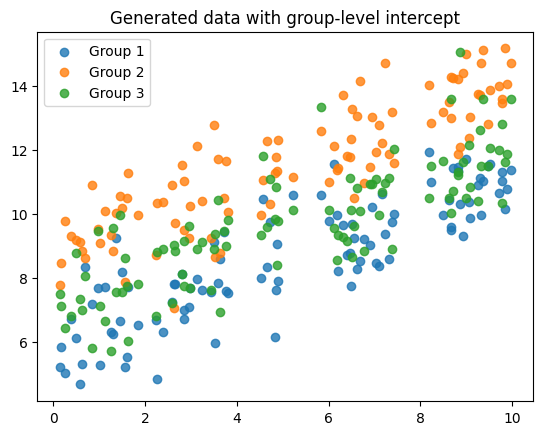

In [198]:
#visualize generated data
plt.scatter(x1, y1, label = 'Group 1', alpha = 0.8)
plt.scatter(x1, y2, label = 'Group 2', alpha = 0.8)
plt.scatter(x1, y3, label = 'Group 3', alpha = 0.8)
plt.legend()
plt.title('Generated data with group-level intercept')

STAN Model Block

In [135]:
group_level_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;

    int<lower=0> J; //number of groups
    array[N] int group;;   //lookup list for each data point's group ID

}

parameters {
    vector[J] alpha;
    real beta;
    real<lower=0> sigma;
}

//combining parameters to make intermediate parameters
transformed parameters {
    vector[N] mu;

    for (n in 1:N){
        mu[n] = alpha[group[n]];
        mu[n] = mu[n] + beta * x[n];
    }

}


model {
    //EXERCISE 2
    beta ~

    for (j in 1:J){
      alpha[j] ~
      }



    for (n in 1:N){
        y[n] ~ normal(mu[n], sigma);
    }
}

generated quantities{
    vector[N] log_lik;
    vector[N] yhat;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | mu[n], sigma);
        yhat[n] = normal_rng( mu[n], sigma);
        }
}

"""

In [209]:
group_level_data = {'N': len(df.x), 'x': df.x.values, 'y': df.y.values,
        'group':df.group.values,'J':df.group.nunique()}
#Note: STAN starts counting at 1

chains = 2
samples = 1000
warmup = 100

# Compile the model
posterior = stan.build(group_level_model, data=group_level_data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/4000)
Sampling:   0% (2/4000)
Sampling:   3% (101/4000)
Sampling:   5% (201/4000)
Sampling:   8% (300/4000)
Sampling:  10% (400/4000)
Sampling:  12% (500/4000)
Sampling:  18% (700/4000)
Sampling:  20% (800/4000)
Sampling:  22% (900/4000)
Sampling:  25% (1000/4000)
Sampling:  28% (1100/4000)
Sampling:  30% (1200/4000)
Sampling:  32% (1300/4000)
Sampling:  35% (1400/4000)
Sampling:  38% (1500/4000)
Sampling:  40% (1601/4000)
Sampling:  60% (2401/4000)
Sampling:  85% (3400/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 0.000854 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000603 seconds
  1000 transition

In [140]:
# Extracting traces
alpha = [fit['alpha'][i].reshape(chains,samples) for i in range(3)]#arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)

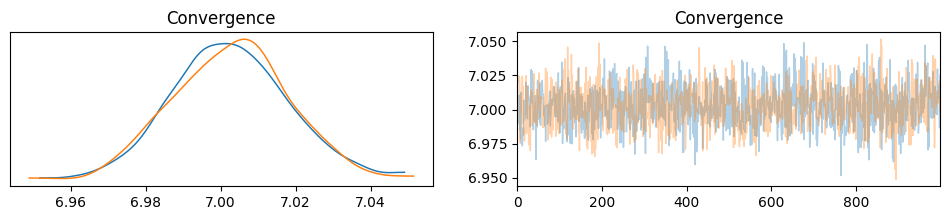

In [143]:
varname = alpha[2]
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('traces')

## **Compare Models**
Next, we run the group-level model and the simple model results for the group-level dataset, and compare the results. Common sense would indicate that the group-level model is a better descriptor of our constructed group-level data. What is a metric that can quantify this?
### Watanabe–Akaike information criterion

https://en.wikipedia.org/wiki/Bayesian_information_criterion


In [144]:
def compute_waic(fit):
    log_lik  = fit['log_lik']
    scale_value=1
    shape         = log_lik.shape
    n_samples     = shape[0]
    n_data_points = shape[1]
    vars_lpd      = np.var(log_lik,axis=0)
    lppd_i        = np.log(np.mean(np.exp(log_lik),axis=0))


    waic_i        = scale_value * (lppd_i - vars_lpd)
    waic_se       = (n_data_points * np.var(waic_i)) ** 0.5
    waic_sum      = np.sum(waic_i)
    p_waic        = np.sum(vars_lpd)
    return [waic_sum,waic_se,p_waic]



# rewrite simple model

In [210]:
simple_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1); //why?

    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma);
        }
}
"""

# Run both the Simple model and Group level model on group level data

In [212]:
#Group-level Model
posterior_group = stan.build(group_level_model, data=group_level_data, random_seed = 42)
fit_group = posterior_group.sample(num_chains=chains, num_samples=samples, random_seed = 42)

#Ignoring Group-level effect
posterior = stan.build(simple_model, data=group_level_data)
fit = posterior.sample(num_chains=chains, num_samples=samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


AssertionError: `random_seed` is set in `build`.

In [ ]:
waic_group = compute_waic(fit_group)
waic = compute_waic(fit)

https://en.wikipedia.org/wiki/Bayesian_information_criterion
print(waic_group, waic)

TAKE HOME EXERCISE


---


Similar to intercept alpha, add Group-Level Effect for slope Beta.